### Learning Physical Informed Neural Networks with JAX

#### Author: Andre Lorenzo Bittencourt

For this tutorial, I will be using a simple PDE model so we can check the results against the analytical solution.

Consider the one-dimension heat equation:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}  
$$

With $u(x,t)$ the temperature, $\alpha$ the diffusion coefficient, $x$ the space and $t$ the time.

The problem has boundary conditions:

$$
u(0,t) = 0 \\
u(L,t) = 0 \\
$$

And initial condition:

$$
u(x,0) = \sin \left (\frac{\pi x}{L}\right)
$$

The <u>solution</u> for this problem is:

$$
u(x,t) = \sin \left (\frac{\pi x}{L}\right) e^{-\alpha \left (\frac{\pi}{L}\right)^2t}
$$

So let's start our code.

In [605]:
# Discoment to activate virtual environment
# !env\Scripts\activate

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc


Let's first define a class for our rod. Notice that I am using jnp (JAX-Numpy) instead of np (Numpy), jnp is verry similar to np.

In [441]:
class Rod():
    ## Class representing the rod

    def __init__(self, alpha, L):
        self.alpha = alpha
        self.L = L

    def solution_u(self, x, t):
        return jnp.sin(jnp.pi * x / self.L)*jnp.exp(-self.alpha * (jnp.pi/self.L)**2 * t)
    
    def solve(self, T, d = 0.01):
        self.T = T
        x_values = jnp.linspace(0, self.L, int(self.L/d))
        t_values = jnp.linspace(0, T, int(T/d))

        self.x_array, self.t_array = jnp.meshgrid(x_values, t_values)
        
        self.solution = self.solution_u(self.x_array, self.t_array)
    
    def plot(self, ax=None):
        if not hasattr(self, 'solution'):
            print("Solve first")
        else:
            if ax is None:
                fig, ax = plt.subplots()

            c = ax.imshow(self.solution.T, extent=[0, self.T, 0, self.L,], aspect='auto', origin='lower', cmap='jet')
            plt.colorbar(c, ax=ax, label='Temperature')
            ax.set_xlabel('Time')
            ax.set_ylabel('Space')
            ax.set_title('Heat Equation | Analytical Solution')

            if ax is None:
                plt.show()



And plot the solution below.

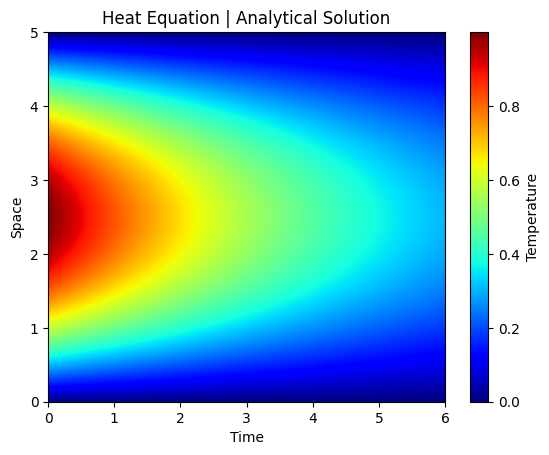

In [493]:
alpha = 0.5
L = 5
T = 6
d=0.005


rod = Rod(alpha, L)
rod.solve(T, d=d)
rod.plot()


Now is time to Neural Networks. In this tutorial I will use JAX and Equinox. Jax is a library developed by Google for high-performance numerical computing, our main interest is its automatic differential capability. Skimming over, automatic differential, or autodiff, is a efficity way to compute function's (including NN) numerical derivatives. JAX offer a numpy-like sintax, autodiff, and vectorized operations. Equinox is a library building using JAX to facilitate Neural Network implementations.

Let's define our Multilayer Perceptron class

In [494]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.sigmoid(layer(x))
        x = self.layers[-1](x)
        return x

To create a NN is simple as:

In [495]:
# Initialize the model with multiple hidden layers and 1 output layer
model_key = jax.random.PRNGKey(1)

layers_size = 10
n_layers = 2
input_dim = 2
output_dim = 1

model = MLP(model_key, input_dim=input_dim, hidden_dims=layers_size, n_layers=n_layers, output_dim=output_dim)

In [496]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model_scalar = MLP(model_key, input_dim=input_dim, hidden_dims=layers_size, n_layers=n_layers, output_dim=output_dim)

Alternatively, we can use the equinox built-in class. Defining our own class give us more flexibility, but using the built-in class is usually enough for most cases.

In [497]:
model_key = jax.random.PRNGKey(1)


output_dim = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

_Important: for 1 output, the output dimension could be 1, which means an array of size one, or the string 'scalar', which returns just the scalar. The choice between 1 and 'scalar' will impact the rest of the implementation._

Feeding an input to test

In [498]:
input = jnp.array([1., 2.])
model(input)

Array([0.06604719], dtype=float32)

If we want to pass a batch of inputs, we must use the jax.vmap function to vectorize our model.

In [499]:
# Example batch input
batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])
batch_output = jax.vmap(model)(batch_input_data)
batch_output

Array([[0.06604719],
       [0.08069957],
       [0.0875187 ]], dtype=float32)

We got a result. Is this the solution for the heat equation? Unless we are extremly lucky, no.

#### So, how are we going to use NN to solve a PDE?

There exist a function $u(x,t)$ fullfiling the PDE, initial and boundary conditions stated in the beggining. If a function fullfils those things, it IS the solution. What if instead of finding THE solution, we find an approximation that attend all the stated conditions close enough?

Well, Neural Networks are universal function approximator, which mean we can approximate any function with any degree of accuracy. The idea is to use the Multilayer Perceptron as an approximation, fullfiling the conditions with a certain degree of accuracy.


"But how do we train the NN if we do not have samples of input-output?" you may ask. That is very good question indeed. That is how PINN differentiate from NN. Our loss functions are constructed having in mind the PDE and initial/boundary conditions, not the model output vs the truth.

## Detour on JAX

### Derivatives in JAX

JAX provides very efficient tools to deal with numerical derivative, making use of autodiff.

For first-order derivatives, we have the functions:



### `jax.grad`

The function `jax.grad` computes the gradient of a function, the vector of partial derivatives wrt each input.


If we are using `'scalar'` output, we use:

In [500]:
jax.grad(model_scalar)(input)

Array([ 0.01311204, -0.0033008 ], dtype=float32)

for a single sample, or:

In [501]:
jax.vmap(jax.grad(model_scalar))(batch_input_data)

Array([[ 0.01311204, -0.0033008 ],
       [ 0.01012372, -0.00521001],
       [ 0.00935027, -0.00701867]], dtype=float32)

for a batch of samples.

If we want just the derivative wrt the i-th input, it is simple array manipulation, including `[:, i]` at the end of the line.

Now, if we are using the `1` output layer, we have to make the trick below to get just the result of the model, using lambda.

In [502]:
jax.grad(lambda x: model(x)[0])(input)

Array([ 0.01311204, -0.0033008 ], dtype=float32)

In [503]:
jax.vmap(jax.grad(lambda x: model(x)[0]))(batch_input_data)

Array([[ 0.01311204, -0.0033008 ],
       [ 0.01012372, -0.00521001],
       [ 0.00935027, -0.00701867]], dtype=float32)

At least for this implementation, there is no performance difference between using the 'scalar' or 1 output.

In [504]:
%timeit timeit
jax.vmap(jax.grad(model_scalar))(batch_input_data)

9.22 ns ± 0.189 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


Array([[ 0.01311204, -0.0033008 ],
       [ 0.01012372, -0.00521001],
       [ 0.00935027, -0.00701867]], dtype=float32)

In [505]:
%timeit timeit
jax.vmap(jax.grad(lambda x: model(x)[0]))(batch_input_data)

9.55 ns ± 0.266 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


Array([[ 0.01311204, -0.0033008 ],
       [ 0.01012372, -0.00521001],
       [ 0.00935027, -0.00701867]], dtype=float32)

### `jax.value_and_grad`

Sometimes, it's useful to have the output and the gradient of a model. That is condesated in the `jax.value_and_grad` function.

In [506]:
value, grad = jax.value_and_grad(model_scalar)(input)
print(value)
print(grad)

0.32397088
[ 0.01311204 -0.0033008 ]


In [507]:
value, grad = jax.vmap(jax.value_and_grad(model_scalar))(batch_input_data)
print(value)
print(grad)

[0.32397088 0.33862326 0.34544238]
[[ 0.01311204 -0.0033008 ]
 [ 0.01012372 -0.00521001]
 [ 0.00935027 -0.00701867]]


In [508]:
jax.value_and_grad(lambda x: model(x)[0])(input)

(Array(0.06604719, dtype=float32),
 Array([ 0.01311204, -0.0033008 ], dtype=float32))

In [509]:
jax.vmap(jax.value_and_grad(lambda x: model(x)[0]))(batch_input_data)

(Array([0.06604719, 0.08069957, 0.0875187 ], dtype=float32),
 Array([[ 0.01311204, -0.0033008 ],
        [ 0.01012372, -0.00521001],
        [ 0.00935027, -0.00701867]], dtype=float32))

It's important to notice that `jax.grad` and `jax.value_and_grad` only work with single-value outputs. We can use for multi-valued models, but we can only get the grad wrt to each output one at time, that is why we have the `[0]` above. If wanted wrt the second output, we would have used `[1]` and so on.

If we want to work with functions with many outputs? Than we have two functions:

### `jax.jacfwd` and `jax.jacrev`

The functions `jax.jacfwd` and `jax.jacrev` both computes the Jacobian matrix, the difference is that the first uses the forward-mode automatic differentiation and the second the reverse-mode. The first is more efficient when the output dimension is larger than the input and second the opposite.

In [510]:
jax.jacfwd(model_scalar)(input)

Array([ 0.01311204, -0.00330079], dtype=float32)

In [511]:
jax.vmap(jax.jacfwd(model_scalar))(batch_input_data)

Array([[ 0.01311204, -0.00330079],
       [ 0.01012372, -0.00521001],
       [ 0.00935027, -0.00701867]], dtype=float32)

In [512]:
# Notice the lack of [0]

jax.jacfwd(lambda x: model(x))(input)

Array([[ 0.01311204, -0.00330079]], dtype=float32)

In [513]:
jax.vmap(jax.jacfwd(lambda x: model(x)))(batch_input_data)

Array([[[ 0.01311204, -0.00330079]],

       [[ 0.01012372, -0.00521001]],

       [[ 0.00935027, -0.00701867]]], dtype=float32)

### Higher order derivatives

For higher order derivatives, we have several options. For single valued outputs, we can use:

### `jax.hessian`

The function `jax.hessian` computes the Hessian matrix.

In [514]:
jax.hessian(model_scalar)(input)

Array([[-0.00117906, -0.00049217],
       [-0.00049217,  0.00013672]], dtype=float32)

_For the sake of brevity, I won't repeat the implementation for the four combinations, {'scalar', 1}*{single input, batch}. The implementation is analougous._

### `jax.grad(jax.grad)`

We can use the nested `jax.grad`. In this case we are getting the gradient of $\frac{\partial f}{\partial x_i}$, i.e. $\left [\frac{\partial^2 f}{\partial x_i x_1}, \frac{\partial^2 f}{\partial x_i x_2}, ..., \frac{\partial^2 f}{\partial x_i x_i}, ....\right]$

In [515]:
jax.grad(lambda x: jax.grad(model_scalar)(x)[0])(input)  #[0] represents the i above.

Array([-0.00117906, -0.00049217], dtype=float32)

As things get a bit tricky, worth to demonstrate the four implementations:

In [516]:
jax.vmap(jax.grad(lambda x: jax.grad(model_scalar)(x)[0]))(batch_input_data)

Array([[-1.1790610e-03, -4.9216527e-04],
       [-7.9429377e-04, -9.8927027e-05],
       [-1.8368490e-04,  1.2211686e-04]], dtype=float32)

In [517]:
jax.grad(lambda x2: jax.grad(lambda x: model(x)[0])(x2)[0])(input)

Array([-0.00117906, -0.00049217], dtype=float32)

In [518]:
jax.vmap(jax.grad(lambda x2: jax.grad(lambda x: model(x)[0])(x2)[0]))(batch_input_data)

Array([[-1.1790610e-03, -4.9216527e-04],
       [-7.9429377e-04, -9.8927027e-05],
       [-1.8368490e-04,  1.2211686e-04]], dtype=float32)

### `jax.jacfwd(jax.jacfwd)`

We can also nest `jax.jacfwd`, to obtain the full hessian matrix:

In [519]:
jax.jacfwd(lambda x: jax.jacfwd(model_scalar)(x))(input) 

Array([[-0.00117906, -0.00049217],
       [-0.00049217,  0.00013672]], dtype=float32)

In [520]:
jax.vmap(jax.jacfwd(lambda x: jax.jacfwd(model_scalar)(x)[0]))(batch_input_data)

Array([[-1.1790612e-03, -4.9216545e-04],
       [-7.9429371e-04, -9.8927325e-05],
       [-1.8368494e-04,  1.2211678e-04]], dtype=float32)

In [521]:
jax.jacfwd(lambda x2: jax.jacfwd(lambda x: model(x)[0])(x2)[0])(input)

Array([-0.00117906, -0.00049217], dtype=float32)

In [522]:
jax.vmap(jax.jacfwd(lambda x2: jax.jacfwd(lambda x: model(x)[0])(x2)[0]))(batch_input_data)

Array([[-1.1790612e-03, -4.9216545e-04],
       [-7.9429371e-04, -9.8927325e-05],
       [-1.8368494e-04,  1.2211678e-04]], dtype=float32)

## Back to the PINN

Know that we learnt a bit more about derivatives in JAX, let's go back to our main problem. Let's define our loss functions (They will be definede having the 'scalar' model in mind).

The first is the PDE loss. We want to minimize the difference between both sides of the PDE equation. This is equivalent to:

$$
\min \left(\frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2}\right)^2
$$

Notice that we need sample points to evaluate the derivative. The ideal is to have points covering the whole space, we can use an equally spaced grid or a Latin Hypercube sample. The second approach requires less sample points per trainning, as well avoind fitting just the point in the equally space grid.

In [523]:
def pde_loss(model, x, alpha):
    
    du_dt = jax.vmap(jax.grad(model))(x)[:, 1] # du/dt
    d2u_dx2 = jax.vmap(jax.hessian(model))(x)[:, 0, 0] # d^2 u/ dx^2

    return jnp.mean((du_dt - alpha * d2u_dx2)**2) # Mean Squared Error

In [524]:
pde_loss(model_scalar, batch_input_data, alpha=alpha)

Array(2.6165186e-05, dtype=float32)

In [525]:
def generate_latin_hypercube_samples(num_samples, x, t):
    # Define the ranges
    parameter_ranges = jnp.array([x, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [526]:
generate_latin_hypercube_samples(10, [0,L], [0,T])

Array([[2.0120015 , 4.201451  ],
       [4.0747023 , 1.1158562 ],
       [1.0125192 , 3.7374294 ],
       [4.7102556 , 4.975194  ],
       [2.9668362 , 0.5878284 ],
       [0.9340685 , 1.9859636 ],
       [0.33651727, 2.4377754 ],
       [3.7595983 , 1.7264532 ],
       [1.5975525 , 5.5596466 ],
       [3.1093073 , 3.2625155 ]], dtype=float32)

Next is the boundary condition loss, we want:


$$
\min \left[u(0,t)^2 + u(L,t)^2\right]
$$


In [527]:
def bc_loss(model, L, T, steps=20):
    t_array = jnp.linspace(0, T, steps) # Time array
    zeros_array = jnp.zeros_like(t_array) # Array of 0s
    L_array = jnp.full_like(t_array, L) # Array of Ls
    u_0 = jnp.stack([zeros_array, t_array], axis=1) # u(0,t)
    u_L = jnp.stack([L_array, t_array], axis=1) # u(L,t)

    return jnp.mean(jax.vmap(model)(u_0) ** 2 + jax.vmap(model)(u_L) ** 2)

In [528]:
bc_loss(model_scalar, L, T)

Array(0.22097778, dtype=float32)

The last, but not least, the initial condition loss.

$$
\min \left[u(x,0) - \sin \left (\frac{\pi x}{L}\right)\right]^2
$$

In [529]:
def ic_loss(model, L, steps=20):
    xs = jnp.linspace(0,L,steps)
    zeros_array = jnp.zeros_like(xs)
    input = jnp.stack([xs, zeros_array], axis=1)

    return jnp.mean((jax.vmap(model)(input) - jnp.sin((jnp.pi/L) * xs))**2)  # If using '1' model, include a .squeeze() in jax.vmap(model)(input).squeeze()


In [530]:
ic_loss(model, L)

Array(0.38199836, dtype=float32)

Combining all the loss functions in a single loss:

In [531]:
def loss(model, x, alpha, L, T, steps=20):
    return pde_loss(model, x, alpha) + bc_loss(model, L, T, steps) + ic_loss(model, L, steps)

In [532]:
loss(model_scalar, batch_input_data, alpha, L, T)

Array(0.39893824, dtype=float32)

The last part of a NN model is to train it.

First, set the optimization. We will be using the optax package and a the Adam optimiser. The optax has many other options and allow for scheduled learning rate, which might be useful in more complex models. We will manually implement a decreasing learning rate.

In [596]:
# Initialize the model with multiple hidden layers and 1 output layer
model_key = jax.random.PRNGKey(1)

layers_size = 15
n_layers = 1
input_dim = 2
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=layers_size, n_layers=n_layers, output_dim=output_dim)

In [597]:
# Optimizer definition
lr = 0.01
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

Define the trainning step, using the usual backward propagation.

In [598]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, x, alpha, L, T):
    loss_value, grads = jax.value_and_grad(loss)(model, x, alpha, L, T) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

Implement the training loop.

In [599]:
# Training loop
num_epochs = 10000
losses = []

solutions = []
x_values = jnp.linspace(0, L, int(L/d))
t_values = jnp.linspace(0, T, int(T/d))
x_grid, t_grid = jnp.meshgrid(x_values, t_values, indexing='ij')
heatmap_input_data = jnp.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)



sample_n = 30
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, x, alpha, L, T)
    if epoch % 100 == 0:
        x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.5
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
final_loss = loss(model, x, alpha, L, T)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 0.7914292216300964
Epoch 100, Loss: 0.14075550436973572
Epoch 200, Loss: 0.05396987125277519
Epoch 300, Loss: 0.015071242116391659
Epoch 400, Loss: 0.006968912202864885
Epoch 500, Loss: 0.0028340942226350307
Epoch 600, Loss: 0.002369414549320936
Epoch 700, Loss: 0.001613443368114531
Epoch 800, Loss: 0.0011626578634604812
Epoch 900, Loss: 0.0009682363597676158
Epoch 1000, Loss: 0.0007007246022112668
Epoch 1100, Loss: 0.0008549421327188611
Epoch 1200, Loss: 0.0004491517611313611
Epoch 1300, Loss: 0.00038745399797335267
Epoch 1400, Loss: 0.00030226135277189314
Epoch 1500, Loss: 0.0002177537971874699
Epoch 1600, Loss: 0.0002036251244135201
Epoch 1700, Loss: 0.00028474724967963994
Epoch 1800, Loss: 0.0001958262437256053
Epoch 1900, Loss: 0.00012392167991492897
Epoch 2000, Loss: 0.0001311408559558913
Epoch 2100, Loss: 0.0001510789297753945
Epoch 2200, Loss: 0.00011939412070205435
Epoch 2300, Loss: 8.756810711929575e-05
Epoch 2400, Loss: 0.00013685548037756234
Epoch 2500, Loss:

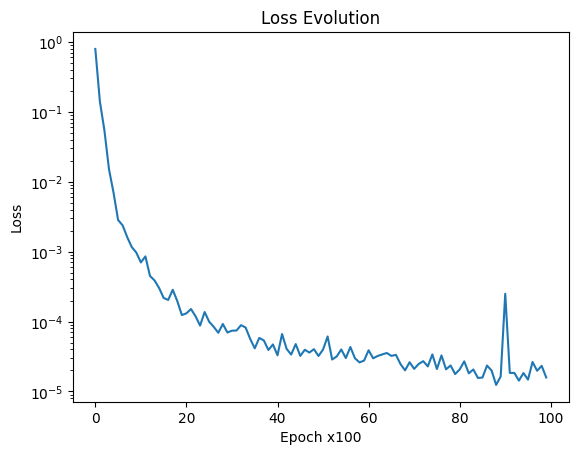

In [600]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

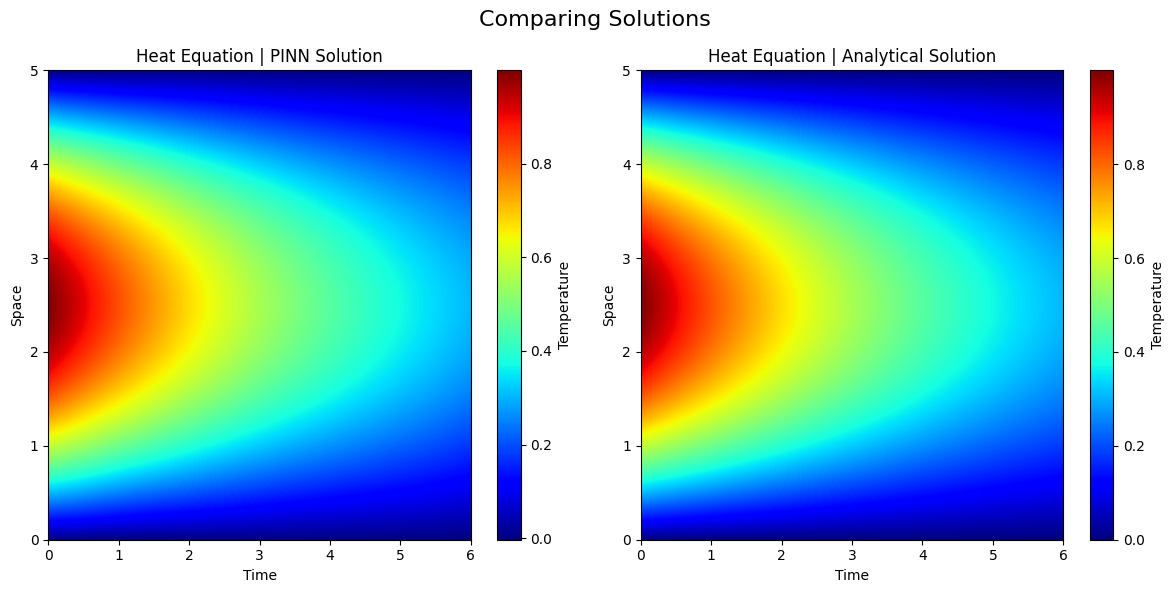

In [601]:
x_values = jnp.linspace(0, L, int(L/d))
t_values = jnp.linspace(0, T, int(T/d))
x_grid, t_grid = jnp.meshgrid(x_values, t_values, indexing='ij')
heatmap_input_data = jnp.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)


# Predict the solution using the trained model
predictions = jax.lax.map(model, heatmap_input_data)
u_values = predictions.reshape(len(x_values), len(t_values))

# Plot the heatmap

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Comparing Solutions", fontsize=16)

hm1 = ax1.imshow(u_values, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='jet')

cb1 = fig.colorbar(hm1, ax=ax1, label='Temperature')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Heat Equation | PINN Solution')

rod.plot(ax2)

plt.tight_layout()

plt.show()



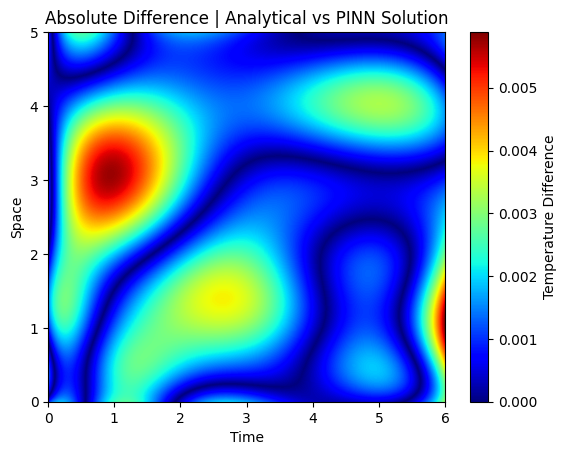

MSE: 4.176356924290303e-06


In [603]:
diff = jnp.abs(u_values-rod.solution.T)

plt.imshow(diff, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='jet')
plt.colorbar(label='Temperature Difference')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Absolute Difference | Analytical vs PINN Solution')
plt.show()

print(f'MSE: {np.mean(diff**2)}')

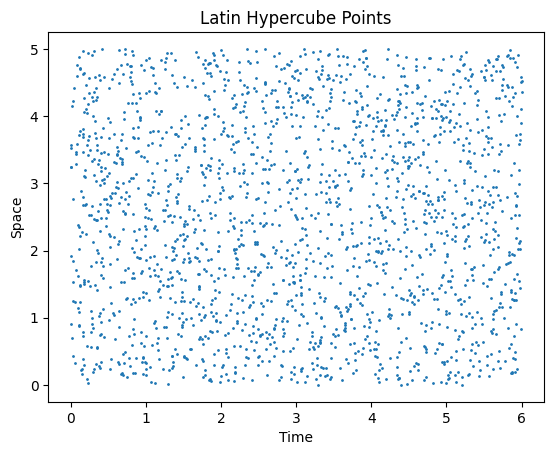

In [595]:
plt.scatter(sample_points.T[1], sample_points.T[0], s=1)
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Latin Hypercube Points')
plt.show()

As we can see, such a simple network, with only 1 hidden layer and 15 nodes on it could approximate the true solution very well, with a MSE on the order of $10^{-6}$.

The attentive reader might have noticed we've used the Sigmoid activation function. But why we made this choice if ReLU is so ubiquitous?

Think about it for a moment, go back and change the NN to use ReLU and see at happens. The answer is hidden in the cell below.

Answer:

<span style="color:transparent; background-color:transparent;">

Our PDE loss function uses a second-order derivative. ReLU only has the first "derivative", so $d^2u/dx^2$ always will be zero.

It doesn't mean a ReLU network cannot approximate our problem, it cannot learn it using the PDE loss, though. I must use a activation with non-constant second derivative.

</span>

I hope this tutorial is useful to you as it was useful to me. Feel free to share it.

In [606]:
!deactivate